In [40]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import chi2

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [2]:
train_df = pd.read_json("new_train.json.zip")
data = train_df.head()

In [3]:
train_df = train_df.head(5000)
train_df.shape

(5000, 26)

In [4]:
all_columns = ['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'latitude', 'listing_id', 'longitude',
       'manager_id', 'photos', 'price', 'street_address', 'interest_level',
       'mean_feature_tdidf', 'mean_des_tdidf', 'closest_hospital',
       'closest_station', 'number_features', 'length_description',
       'created_hour', 'created_year', 'created_month', 'created_day',
       'photos_num']

In [5]:
cols = ['bedrooms', 'bathrooms', 'latitude', 
        'longitude', 'price', 'number_features', 
        'length_description', 'closest_station', 'closest_hospital',
        'created_month', 'created_day', 'created_hour', 'photos_num', 
        'mean_des_tdidf', 'mean_feature_tdidf']

In [6]:
X = train_df[cols]
y = train_df['interest_level']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)

In [7]:
model = SVC(gamma='auto')
model.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [8]:
# score = model.score(X_valid, y_valid)
# print(score)
accuracies = cross_val_score(estimator=model,X=X_train,y=y_train,cv=5)
accuracies

array([0.69373219, 0.69329529, 0.69384835, 0.69527897, 0.69241774])

In [9]:
cols = ['bedrooms', 'bathrooms', 'latitude', 
        'price', 'number_features', 
        'length_description', 'closest_station', 'closest_hospital',
        'created_month', 'created_day', 'created_hour', 'photos_num', 
        'mean_des_tdidf', 'mean_feature_tdidf']

X = train_df[cols]
y = train_df['interest_level']

# Performing feature selection
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                 Specs          Score
3                price  227148.275485
5   length_description    8040.324003
10        created_hour     458.998667
9          created_day     102.266257
4      number_features      69.326557
11          photos_num      31.857104
1            bathrooms       8.714913
0             bedrooms       1.992719
13  mean_feature_tdidf       1.074995
12      mean_des_tdidf       0.456458


[0.06527261 0.02035425 0.08621345 0.11845033 0.07029007 0.08852296
 0.07541601 0.07896719 0.00029798 0.07920499 0.0847429  0.07328984
 0.07824889 0.08072853]
price                 0.118450
length_description    0.088523
latitude              0.086213
created_hour          0.084743
mean_feature_tdidf    0.080729
created_day           0.079205
closest_hospital      0.078967
mean_des_tdidf        0.078249
closest_station       0.075416
photos_num            0.073290
dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


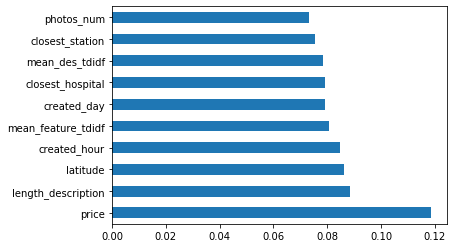

In [10]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
# plt.show()
print(feat_importances.nlargest(10))

In [12]:
top_cols = ['price', 'latitude', 'mean_des_tdidf', 
            'length_description', 'created_hour', 'closest_hospital',
            'closest_station', 'mean_feature_tdidf', 'created_day',
            'photos_num']

new_train_df = train_df[top_cols]
# corrmat = train_df[top_cols].corr()
# top_corr_features = corrmat.index
# plt.figure(figsize=(10,10))
# #plot heat map
# g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [52]:
# Tying to improve model accuracy 
X = new_train_df
y = train_df['interest_level']
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)

model = make_pipeline(
        StandardScaler(),
        PCA(n_components=2),
        SVC(kernel='rbf', gamma=0.1, C=10)
    )

# model.fit(X_train, y_train)
# score = model.score(X_valid, y_valid)
# print(score)

accuracies = cross_val_score(estimator=model,X=X,y=y,cv=5, scoring='accuracy')
accuracies
print('Training accuracy :', np.mean(accuracies))

Training accuracy : 0.6970002788002787


In [55]:
# Parameter Tuning

# parameters = [{'C':[0.01,0.1,1,10,50,100,500,1000], 'kernel':['rbf'], 'gamma': [0.1,0.125,0.15,0.17,0.2]}]
# grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring ='accuracy',cv=5,n_jobs=-1)
# grid_search = grid_search.fit(X_train,y_train)

# best_accuracy = grid_search.best_score_
# best_accuracy
# opt_param = grid_search.best_params_
# opt_param
# Best params are {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

In [43]:
# X = new_train_df
# y = train_df['interest_level']

# model = make_pipeline(
#         SVC(gamma='auto')
#     )

# model.fit(X_train, y_train)
# # score = model.score(X_valid, y_valid)
# # print(score)

# accuracies = cross_val_score(estimator=model,X=X,y=y,cv=5)
# accuracies
# print('Training accuracy :', np.mean(accuracies))

# predictions = model.predict(X_valid)
# test_accuracy = accuracy_score(predictions, y_valid)
# print('Test accuracy :', test_accuracy)

Training accuracy : 0.6962004786004785
Test accuracy : 0.688


In [ ]:
test_df = pd.read_json("new_test.json.zip")
# X = test_df[top_cols]
# y = test_df['interest_level']

# accuracies = cross_val_score(estimator=model,X=X,y=y,cv=5, scoring='accuracy')
# accuracies
# print('Training accuracy :', np.mean(accuracies))
test_df.columns

In [51]:
y_pred = model.predict_proba(X)

submission = pd.DataFrame({
    "listing_id": test_df["listing_id"],
    "high": y_pred[:,0],
    "medium":y_pred[:,1],
    "low":y_pred[:,2]
})

titles_columns=["listing_id","high","medium","low"]
submission=submission.reindex(columns=titles_columns)
submission.to_csv('improved_submission.csv', index=False)

AttributeError: predict_proba is not available when  probability=False